In [42]:
import arviz as az
import pandas as pd
import json
import os

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import sys
from scipy.stats import mode

sys.path.append("../models/")
from huang_ferrell_1996 import *
from bhalla_iyengar_1999 import *
from kholodenko_2000 import *
from levchenko_2000 import *
from brightman_fell_2000 import *
from schoeberl_2002 import *
from hatakeyama_2003 import *
from hornberg_2005 import *
from birtwistle_2007 import *
from orton_2009 import *
from vonKriegsheim_2009 import *
from shin_2014 import *
from ryu_2015 import *
from kochanczyk_2017 import *
from dessauges_2022 import *

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('/home/nlinden/.matplotlib/custom.mplstyle')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
sys.path.insert(0, '/home/nlinden/.matplotlib/')
from plotting_helper_funcs import *

sys.path.insert(0, '../param_est/')
from sampling_utils import *

rng = np.random.default_rng(seed=1234)

%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [23]:
def load_smc_samples_to_idata(samples_json):
    """ Load SMC samples from json file to arviz InferenceData object """
    with open(samples_json, 'r') as f:
        data = json.load(f)
    
    # create idata object from dictionary
    # ignore sample stats because that changes with each SMC chain
    idata = az.from_dict(
        posterior =  data['posterior'],
        posterior_attrs = data['posterior_attrs'],
        # sample_stats = data['sample_stats'],
        observed_data = data['observed_data'],
        observed_data_attrs = data['observed_data_attrs'],
        log_likelihood = data['log_likelihood'],
        log_likelihood_attrs = data['log_likelihood_attrs'],
        constant_data = data['constant_data'],
        constant_data_attrs = data['constant_data_attrs'],
        attrs = data['attrs'],
    )

    sample_stats = data['sample_stats']

    return idata, sample_stats

## Synthetic Data

In [128]:
# Kholodenko 2000
K_2000_idata, K_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/kholodenko_2000/kholodenko_2000_smc_samples.json')
K_2000_post = np.load('../../../results/MAPK/param_est/synthetic_data/kholodenko_2000/kholodenko_2000_posterior_predictive_samples.npy')
# Levchenko 2000
L_2000_idata, L_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/levchenko_2000/levchenko_2000_smc_samples.json')
L_2000_post = np.load('../../../results/MAPK/param_est/synthetic_data/levchenko_2000/levchenko_2000_posterior_predictive_samples.npy')
# Hatakeyama 2003
HK_2003_idata, HK_2003_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/hatakeyama_2003/hatakeyama_2003_smc_samples.json')
HK_2003_post = np.load('../../../results/MAPK/param_est/synthetic_data/hatakeyama_2003/hatakeyama_2003_posterior_predictive_samples.npy')
# Hornberg 2005
H_2005_idata, H_2005_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/hornberg_2005/hornberg_2005_smc_samples.json') # TODO: add once smc is done
H_2005_post = np.load('../../../results/MAPK/param_est/synthetic_data/hornberg_2005/hornberg_2005_posterior_predictive_samples.npy')
# Birtwistle 2007
B_2007_idata, B_2007_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/birtwistle_2007/birtwistle_2007_smc_samples.json')
B_2007_post = np.load('../../../results/MAPK/param_est/synthetic_data/birtwistle_2007/birtwistle_2007_posterior_predictive_samples.npy')
# Orton 2009
O_2009_idata, O_2009_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/orton_2009/orton_2009_smc_samples.json') # TODO: add once smc is done
O_2009_post = np.load('../../../results/MAPK/param_est/synthetic_data/orton_2009/orton_2009_posterior_predictive_samples.npy')
# von Kreigsheim 2009
# vK_2009_idata, ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/von_kreigsheim_2009/von_kreigsheim_2009_smc_samples.json') # TODO: add once smc is done
# vK_2009_post = np.load('../../../results/MAPK/param_est/synthetic_data/von_kreigsheim_2009/von_kreigsheim_2009_posterior_predictive_samples.npy')
# Shin 2014
S_2014_idata, S_2014_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/shin_2014/shin_2014_smc_samples.json')
S_2014_post = np.load('../../../results/MAPK/param_est/synthetic_data/shin_2014/shin_2014_posterior_predictive_samples.npy')
# Ryu 2015
R_2015_idata, R_2015_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/ryu_2015/ryu_2015_smc_samples.json') # TODO: add once smc is done
R_2015_post = np.load('../../../results/MAPK/param_est/synthetic_data/ryu_2015/ryu_2015_posterior_predictive_samples.npy')
# Kochańczyk 2017
K_2017_idata, K_2017_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/kochanczyk_2017/kochanczyk_2017_smc_samples.json') # TODO: add once smc is done
K_2017_post = np.load('../../../results/MAPK/param_est/synthetic_data/kochanczyk_2017/kochanczyk_2017_posterior_predictive_samples.npy')

model_names = ['kholodenko_2000', 'levchenko_2000', 'hatakeyama_2003','hornberg_2005', 'birtwistle_2007', 'orton_2009', 'shin_2014', 'ryu_2015', 'kochanczyk_2017']
display_names = ['Kholodenko 2000', 'Levchenko 2000', 'Katakeyama 2003','Hornberg 2005', 'Birtwistle 2007', 'Orton 2009', 'Shin 2014', 'Ryu 2015', 'Kochańczyk 2017']

# gather posterior samples
posterior_samples = [K_2000_post, L_2000_post, HK_2003_post, H_2005_post, B_2007_post, O_2009_post, S_2014_post, R_2015_post, K_2017_post]
shin_id = 4
# shin has 16000 so downsample to 4000
idxs = rng.choice(np.arange(16000), size=4000, replace=False)
posterior_samples[shin_id] = S_2014_post[idxs]

# get data
inputs, data = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')
HF_trajs = np.load('../../../results/MAPK/HF_96_trajs.npy')
# set up a color palette
colors = sns.color_palette('pastel', n_colors=len(model_names)+2)

# sns.color_palette("husl", len(model_names)+2)

#### Remake posterior predictive dose repsonse in a more compact form

In [25]:
def plot_stimulus_response_curve(samples, data, inputs, box_color='k', data_color='r', input_name='EGF stimulus', 
                                 output_name='% maximal ERK activity',
                                 data_std=0.1, width=6.0, height=3.0, scatter_marker_size=50, data_marker_size=7):
    dat = {}
    for i,input in enumerate(inputs):
        dat[input] = samples[:,i]

    data_df = pd.DataFrame(dat)

    fig, ax = plt_func.get_sized_fig_ax(width, height)
    sns.boxplot(data=data_df, color=box_color, ax=ax, whis=(2.5, 97.5), fill=True, 
                native_scale=True, log_scale=(10, 0), fliersize=0, width=0.65)
    ax.set_xlabel(input_name)
    ax.set_ylabel(output_name)

    errors = data_std*np.squeeze(np.ones_like(data))
    ax.scatter(inputs, data, color=data_color, marker='x', s=scatter_marker_size, zorder=10, label='synthetic data')
    ax.errorbar(inputs, np.squeeze(data), yerr=errors, color=data_color, fmt='x', markersize=data_marker_size, zorder=10)

    return fig, ax

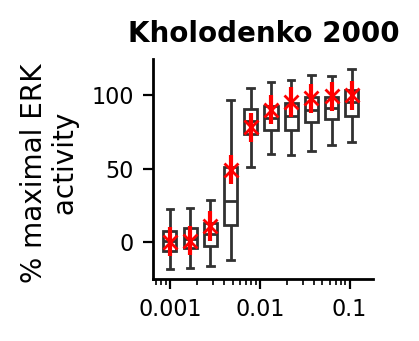

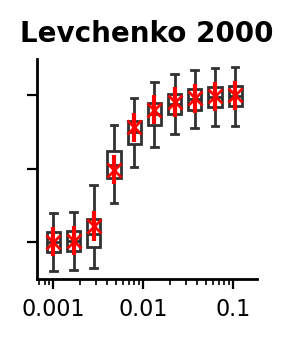

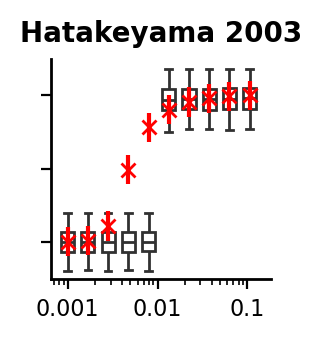

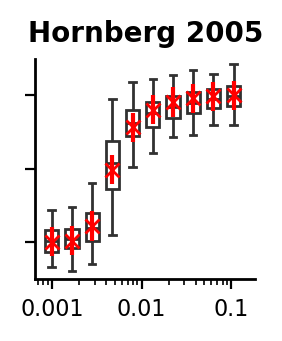

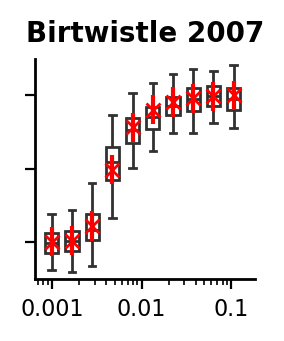

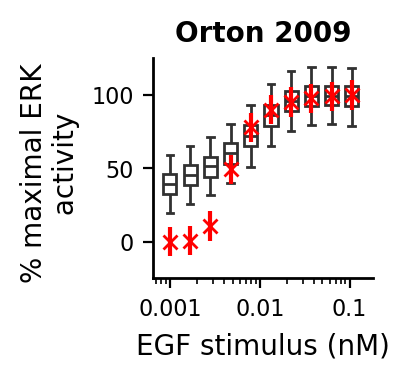

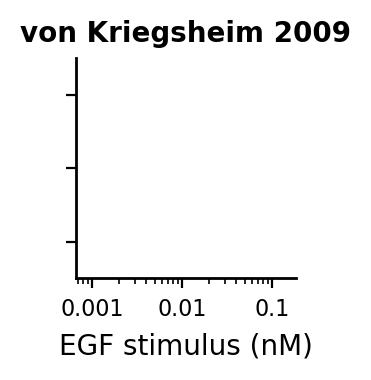

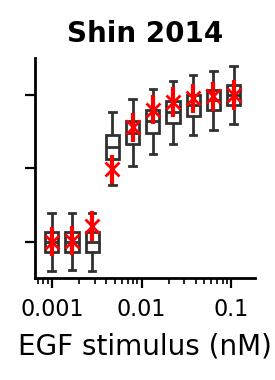

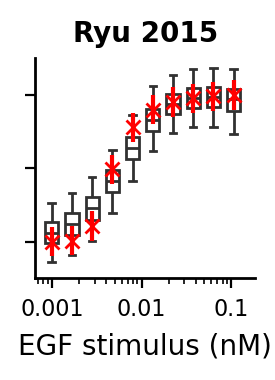

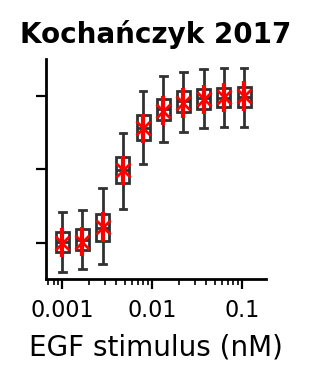

In [26]:
fig, ax = plot_stimulus_response_curve(K_2000_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_title('Kholodenko 2000', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/K_2000_posterior_predictive.pdf', transparent=True)


fig, ax = plot_stimulus_response_curve(L_2000_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Levchenko 2000', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/L_2000_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(HK_2003_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Hatakeyama 2003', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/HK_2003_posterior_predictive.pdf', transparent=True)

# TODO: Hornberg 2005
fig, ax = fig, ax = plot_stimulus_response_curve(H_2005_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
ax.set_xlim([0.0006539278817108092, 0.18412936150507658])
ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Hornberg 2005', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/H_2005_posterior_predictive.pdf', transparent=True)


fig, ax = plot_stimulus_response_curve(B_2007_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Birtwistle 2007', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/B_2007_posterior_predictive.pdf', transparent=True)


fig, ax = plot_stimulus_response_curve(O_2009_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_title('Orton 2009', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/O_2009_posterior_predictive.pdf', transparent=True)

# TODO: von Kriegsheim 2009
fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
# ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_xlim([0.0006539278817108092, 0.18412936150507658])
ax.set_ylabel('')
ax.set_title('von Kriegsheim 2009', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/VK_2009_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(S_2014_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Shin 2014', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/S_2014_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(R_2015_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Ryu 2015', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/R_2015_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(K_2017_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Kochańczyk 2017', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/K_2017_posterior_predictive.pdf', transparent=True)

In [162]:
vsolve_params_traj = jax.vmap(solve_traj, in_axes=(None, None, 0, None, None, None))

def generate_trajectories(model_name, idata, n_traj, max_time, time_conversion_to_min, n_timpoints, EGF, EGF_conversion_factor, EGF_state_name, ERK_state_names, stim_type='False'):
    """ Plot trajectories for a given model """

    model = eval(model_name + '(transient={})'.format(stim_type))
 
    # get parameter names and initial conditions
    p_dict, _ = model.get_nominal_params()
    y0_dict, _ = model.get_initial_conditions()

    # convert EGF to required units
    EGF = EGF * EGF_conversion_factor

    # set EGF in the IC
    y0_dict[EGF_state_name] = EGF
    y0 = list(y0_dict.values())

    # set up time points
    times = np.linspace(0, max_time, n_timpoints)

     # get parameter samples
    parameter_samples = get_param_subsample(idata, n_traj, p_dict)

    # get idxs of ERK states
    ERK_idxs = []
    for ERK_state in ERK_state_names:
        ERK_idxs.append(list(y0_dict.keys()).index(ERK_state))
    trajectories = np.array(vsolve_params_traj(diffrax.ODETerm(model), y0, parameter_samples, max_time, ERK_idxs, times))

    converted_times = times*time_conversion_to_min

    return trajectories, converted_times, parameter_samples

def plot_trajectories(trajectories, times, n_traj, display_name, color='k', width=6.0, height=3.0,):
    # plot this
    fig, ax = get_sized_fig_ax(width, height)
    for i in range(n_traj):
        ax.plot(times, trajectories[i,:], color=color, linewidth=0.5, alpha=0.5)

    ax.set_xlabel('Time (min)', fontsize=10.0)
    ax.set_ylabel('ERK activity', fontsize=10.0)
    ax.set_title(display_name, fontsize=10.0)
    ticks = np.linspace(0, times[-1], 5)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, fontsize=8)

    return fig, ax

def get_param_subsample(idata, n_traj, p_dict):
    dat = idata.posterior.to_dict() # convert to dictionary
    free_params = list(dat['data_vars'].keys()) # figure out which params are free
    # get total number of MCMC samples
    n_samples = np.array(dat['data_vars'][free_params[0]]['data']).reshape(-1).shape[0]

    # extract samples for free params ot dict of numpy arrays
    free_param_samples = {}
    for param in free_params:
        free_param_samples[param] = np.array(dat['data_vars'][param]['data']).reshape(-1)

    # randomly select n_traj samples
    param_samples = []
    idxs = rng.choice(np.arange(n_samples), size=n_traj, replace=False)
    for i in idxs:
        tmp = []
        for param in p_dict.keys():
            if param in free_params:
                tmp.append(free_param_samples[param][i])
            else:
                tmp.append(p_dict[param])
        param_samples.append(tmp)
 
    return np.array(param_samples)

def time_to_max(trajectory, times):
    """ Get the time to max ERK activity and idx of max"""
    max_idx = np.argmax(trajectory)
    return times[max_idx], max_idx

def time_to_half_max(trajectory, times):
    """ Get the time to half max ERK activity and idx of half max"""
    max_idx = np.argmax(trajectory)
    max_val = trajectory[max_idx]
    half_max_val = max_val/2
    # get idx of first value that is greater than half max
    idx = np.where(trajectory > half_max_val)[0][0]
    return times[idx], idx

def full_half_max_width(trajectory, times):
    # get the half max time and idx
    half_max_time, half_max_idx = time_to_half_max(trajectory, times)
    
    # also get max_idx, max, and half-max
    max_idx = np.argmax(trajectory)
    max_val = trajectory[max_idx]
    half_max = max_val/2

    # get idx of values that are less than half max
    idxs = np.array(np.where(trajectory <= half_max)[0])
    idx = np.where(idxs > half_max_idx)
    if len(idx[0]) != 0:
        second_half_max_idx = idxs[idx[0][0]]
    else:
        second_half_max_idx = len(trajectory)-1

    return times[second_half_max_idx] - times[half_max_idx], second_half_max_idx

def sustained_activity_metric(trajectory, index_of_interest, max_val=None):
    # get max idx and max
    if max_val is None:
        max_idx = np.argmax(trajectory)
        max_val = trajectory[max_idx]

    return (trajectory[index_of_interest] - trajectory[0])/(max_val - trajectory[0])

def normalize_traj(trajectory, max_val=None):
    # get max idx and max
    if max_val is None:
        max_val = np.max(trajectory)

    return (trajectory - trajectory[0])/(max_val - trajectory[0])

def plot_trajectory_metric_hist(trajectory, metric_func, metric_name, width=1.0, height=1.0, color='k', fig=None, ax=None):
    """ Plot histogram of a given metric for a given trajectory """
    # apply metric function to each trajectory
    metrics = np.apply_along_axis(metric_func, 1, trajectory)

    if fig is None and ax is None:
        fig, ax = get_sized_fig_ax(width, height)

    sns.histplot(metrics, kde=True, ax=ax, color=color, stat='density')
    ax.set_ylabel('density', fontsize=10.0)
    ax.set_xlabel(metric_name, fontsize=10.0)
    return fig, ax

def get_trajectories(model_name, idata, ntraj, max_time, 
                            time_conversion, ntimes, EGF_state_name, 
                            EGF_conversion_factor, ERK_state_names, inputs, data_savedir,):

    # get the trajectories
    trajs = {}
    global_max = 0.0
    for input in inputs:
        trajs[input], converted_times, param_samples = generate_trajectories(model_name, idata, ntraj, max_time,
                            time_conversion, ntimes, input, EGF_conversion_factor,
                            EGF_state_name, ERK_state_names)
        # save raw traj
        np.save(os.path.join(data_savedir, model_name, 'EGF_{}.npy'.format(input)), trajs[input])
        global_max = np.max([global_max, np.max(trajs[input])])

        # save param_samples
        np.save(os.path.join(data_savedir, model_name, 'PARAMS_EGF_{}.npy'.format(input)), param_samples)
    
    # normalize & save normalized trajs
    trajs_norm = {}
    for input in inputs:
        trajs_norm[input] = np.apply_along_axis(normalize_traj, 1, trajs[input], global_max)
        np.save(os.path.join(data_savedir, model_name, 'EGF_normalized_{}.npy'.format(input)), trajs[input])

    return trajs, trajs_norm, converted_times

def make_plots(model_name, display_name, inputs, n_traj, trajs, trajs_conv, times,  
    figure_savedir, HF_trajs):
    traj_plot_width = 1.75
    traj_plot_height = 0.75
    cb = sns.color_palette("crest", n_colors=len(inputs))

    # spaghetti plots
    plot_objs = {}
    for idx, input in enumerate(inputs):
        s_fig, s_ax = plot_trajectories(trajs_conv[input], times, n_traj, display_name, color=cb[idx], width=traj_plot_width, height=traj_plot_height,)
        s_ax.set_ylim([0.0, 1.0])
        s_ax.set_xlim([0.0, 120.0])
        s_ax.set_title(display_name + '\n EGF=' + str(np.round(input, decimals=3)),
            fontsize=10.0)
        
        s_fig.savefig(os.path.join(figure_savedir, model_name+'_spaghetti_EGF_{}.pdf'.format(input)), transparent=True)

        # mean + 95% credible plot
        tr_dict =  {'run':{}, 'timepoint':{}, 'ERK_act':{}}
        names = ['run'+str(i) for i in range(n_traj)]
        idxs = np.linspace(0, (n_traj*times.shape[0]-1), n_traj*times.shape[0])
        cnt = 0
        for i in range(n_traj):
            for j in range(times.shape[0]):
                tr_dict['run'][int(idxs[cnt])] = names[i]
                tr_dict['timepoint'][int(idxs[cnt])] = times[j]
                tr_dict['ERK_act'][int(idxs[cnt])] = trajs_conv[input][i,j]
                cnt += 1
        tr_df = pd.DataFrame.from_dict(tr_dict)

        fig, ax = get_sized_fig_ax(traj_plot_width, traj_plot_height)
        sns.lineplot(data=tr_df,
                x='timepoint',
                y='ERK_act',
                color=cb[idx],
                legend=False,
                errorbar=('pi', 95), # percentile interval form 2.5th to 97.5th
                ax=ax)
        ax.set_ylim([0.0, 1.0])
        ax.set_xlim([0.0, 120.0])

        ax.plot(np.linspace(0.0, 1000.0, len(HF_trajs[idx])), HF_trajs[idx], 'k--', linewidth=2.0)

        ax.set_xlabel('Time (min)', fontsize=10.0)
        ax.set_ylabel('ERK activity', fontsize=10.0)
        ax.set_title(display_name, fontsize=10.0)
        ticks = np.linspace(0, times[-1], 5)
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks, fontsize=8)
        ax.set_title(display_name + '\n EGF=' + str(np.round(input, decimals=3)),
            fontsize=10.0)

        fig.savefig(os.path.join(figure_savedir, model_name+'_credible_EGF_{}.pdf'.format(input)), transparent=True)


### Generate trajectories for each model
We need to normalize these to some model-specific maximum. For this we will use the max value over all trajectories for each model

In [157]:
data_savedir = '../../../results/MAPK/param_est/synthetic_data/'
fig_savedir = '../../../figures/MAPK/param_est/'
# Kholodenko 2000
K_2000_traj, K_2000_traj_norm, K_2000_converted_times = get_trajectories(
    'kholodenko_2000', K_2000_idata, 400, 7200, 1/60, 100, 
    'Input', 1.0, ['MAPK_PP'], inputs[[0,3,9]], data_savedir)

# Levchenko 2000
L_2000_traj, L_2000_traj_norm, L_2000_converted_times = get_trajectories(
    'levchenko_2000', L_2000_idata, 400, 7200, 1/60, 100, 'RAFact', 0.001, 
    ['MAPKstarstar'], inputs[[0,3,9]], data_savedir)

# Hatakeyama 2003
HK_2003_traj, HK_2003_traj_norm, HK_2003_converted_times = get_trajectories(
    'hatakeyama_2003', HK_2003_idata, 400, 7200, 1/60, 100, 'HRG', 1, ['ERKPP'],
    inputs[[0,3,9]], data_savedir)

# Hornberg 2005
H_2005_traj, H_2005_traj_norm, H_2005_converted_times = get_trajectories(
    'hornberg_2005', H_2005_idata, 400, 7200, 1/60, 100, 'c1', 0.000000001, 
    ['c59','c83'], inputs[[0,3,9]], data_savedir)

# Birtwistle 2007
B_2007_traj, B_2007_traj_norm, B_2007_converted_times = get_trajectories(
    'birtwistle_2007', B_2007_idata, 400, 7200, 1/60, 100, 'E', 1.0, 
    ['ERKstar','ERKstar_ERKpase'], inputs[[0,3,9]], data_savedir)

# Orton 2009
O_2009_traj, O_2009_traj_norm, O_2009_converted_times = get_trajectories(
    'orton_2009', O_2009_idata, 400, 120, 1, 100,'EGF', 602214, ['ErkActive'],
    inputs[[0,3,9]], data_savedir)

# VonKriegsheim 2009
# TODO: run when inference is complete
# VK_2009_traj, VK_2009_traj_norm, VK_2009_converted_times = get_trajectories(
#     'vonKriegsheim_2009', VK_2009_idata, 400, 120, 1, 100, 'EGF', 6.048, 
#     ['ppERK','ppERK_15','ppERKn'],inputs[[0,3,9]], data_savedir)

# Shin 2014
S_2014_traj, S_2014_traj_norm, S_2014_converted_times = get_trajectories(
    'shin_2014', S_2014_idata, 400, 120, 1, 100, 'EGF',  0.001, ['pp_ERK'],
    inputs[[0,3,9]], data_savedir)

# Ryu 2015
R_2015_traj, R_2015_traj_norm, R_2015_converted_times = get_trajectories(
    'ryu_2015', R_2015_idata, 400, 120, 1, 100, 'EGF', 6.048, ['ERK_star'],
    inputs[[0,3,9]], data_savedir)

# Kochanczyk 2017
K_2017_traj, K_2017_traj_norm, K_2017_converted_times = get_trajectories(
    'kochanczyk_2017', K_2017_idata, 400, 7200, 1/60, 100, 'EGF', 6048, ['ERKSPP'],
    inputs[[0,3,9]], data_savedir)

KeyboardInterrupt: 

### Make plots for each model
We will make the following plots:
- Normalized trajectory - spaghetti
- Normalized trajectory - avg + std
- SAM60
- Tmax

In [146]:
# normalize HF_trajs
HF_trajs_norm = np.apply_along_axis(normalize_traj, 1, np.squeeze(HF_trajs), np.max(HF_trajs))

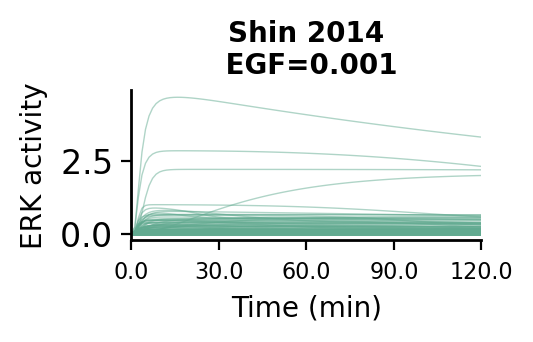

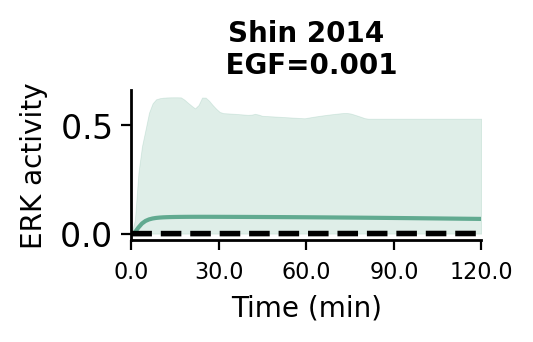

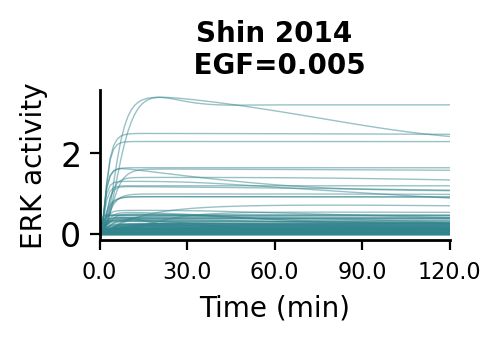

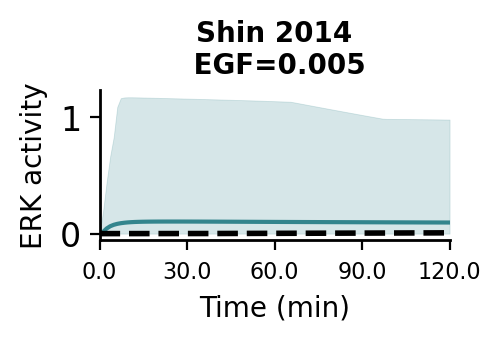

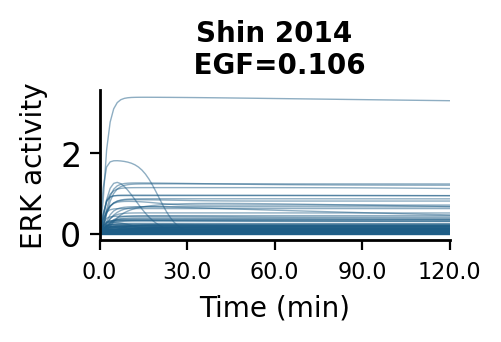

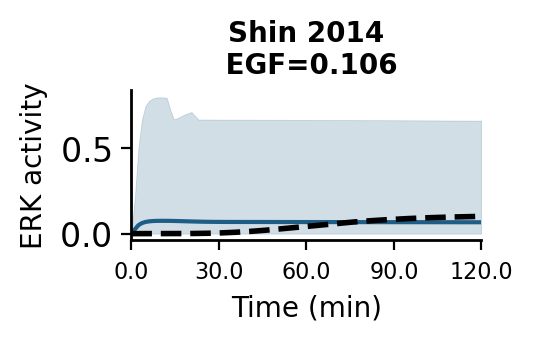

In [163]:
# # Kholodenko 2000
# make_plots('K_2000', 'Kholodenko 2000', inputs[[0,3,9]], 400, K_2000_traj, K_2000_traj_norm, K_2000_converted_times, fig_savedir, HF_trajs_norm[[0,3,9]])
# plt.close('all')

# # Levchenko 2000
# make_plots('L_2000', 'Levchenko 2000', inputs[[0,3,9]], 400, L_2000_traj, L_2000_traj_norm, L_2000_converted_times, fig_savedir, HF_trajs_norm)
# plt.close('all')

# # Hatakeyama 2003
# make_plots('HK_2003', 'Hatakeyama 2003', inputs[[0,3,9]], 400, HK_2003_traj, HK_2003_traj_norm, HK_2003_converted_times, fig_savedir, HF_trajs_norm)
# plt.close('all')

# # Hornberg 2005
# make_plots('H_2005', 'Hornberg 2005', inputs[[0,3,9]], 400, H_2005_traj, H_2005_traj_norm, H_2005_converted_times, fig_savedir, HF_trajs_norm)
# plt.close('all')

# # Birtwistle 2007
# make_plots('B_2007', 'Birtwistle 2007', inputs[[0,3,9]], 400, B_2007_traj, B_2007_traj_norm, B_2007_converted_times, fig_savedir, HF_trajs_norm)
# plt.close('all')

# # Orton 2009
# make_plots('O_2009', 'Orton 2009', inputs[[0,3,9]], 400, O_2009_traj, O_2009_traj_norm, O_2009_converted_times, fig_savedir, HF_trajs_norm)
# plt.close('all')

# vonKriegsheim 2009
# make_plots('VK_2009', 'vonKriegsheim 2009', inputs[[0,3,9]], 400, VK_2009_traj, VK_2009_traj_norm, VK_2009_converted_times, fig_savedir, HF_trajs_norm)
# plt.close('all')

# Shin 2014
make_plots('S_2014', 'Shin 2014', inputs[[0,3,9]], 400, S_2014_traj, S_2014_traj, S_2014_converted_times, fig_savedir, HF_trajs_norm)
# plt.close('all')

# # Ryu 2015
# make_plots('R_2015', 'Ryu 2015', inputs[[0,3,9]], 400, R_2015_traj, R_2015_traj_norm, R_2015_converted_times, fig_savedir, HF_trajs_norm)
# plt.close('all')

# # Kochanczyk 2017
# make_plots('K_2017', 'Kochanczyk 2017', inputs[[0,3,9]], 400, K_2017_traj, K_2017_traj_norm, K_2017_converted_times, fig_savedir, HF_trajs_norm)
# plt.close('all')

## Real Data

In [ ]:
# Kholodenko 2000
# K_2000_idata, K_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/kholodenko_2000_smc_samples.json')
# K_2000_post = np.load('../../../results/MAPK/param_est/real_data/kholodenko_2000_posterior_predictive_samples.npy')
# Levchenko 2000
L_2000_idata, L_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/levchenko_2000_smc_samples.json')
L_2000_post = np.load('../../../results/MAPK/param_est/real_data/levchenko_2000_posterior_predictive_samples.npy')
# Hatakeyama 2003
HK_2003_idata, HK_2003_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/hatakeyama_2003_smc_samples.json')
HK_2003_post = np.load('../../../results/MAPK/param_est/real_data/hatakeyama_2003_posterior_predictive_samples.npy')
# Hornberg 2005
# H_2005_idata, ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/hornberg_2005_smc_samples.json') # TODO: add once smc is done
# H_2005_post = np.load('../../../results/MAPK/param_est/real_data/hornberg_2005_posterior_predictive_samples.npy')
# Birtwistle 2007
# B_2007_idata, ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/birtwistle_2007_smc_samples.json')
# B_2007_post = np.load('../../../results/MAPK/param_est/real_data/birtwistle_2007_posterior_predictive_samples.npy')
# Orton 2009
O_2009_idata, O_2009_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/orton_2009_smc_samples.json') # TODO: add once smc is done
O_2009_post = np.load('../../../results/MAPK/param_est/real_data/orton_2009_posterior_predictive_samples.npy')
# von Kreigsheim 2009
# vK_2009_idata, ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/von_kreigsheim_2009_smc_samples.json') # TODO: add once smc is done
# vK_2009_post = np.load('../../../results/MAPK/param_est/real_data/von_kreigsheim_2009_posterior_predictive_samples.npy')
# Shin 2014
S_2014_idata, S_2014_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/shin_2014_smc_samples.json')
S_2014_post = np.load('../../../results/MAPK/param_est/real_data/shin_2014_posterior_predictive_samples.npy')
# Ryu 2015
R_2015_idata, R_2015_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/ryu_2015_smc_samples.json') # TODO: add once smc is done
R_2015_post = np.load('../../../results/MAPK/param_est/real_data/ryu_2015_posterior_predictive_samples.npy')
# Kochańczyk 2017
# K_2017_idata, K_2017_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/kochanczyk_2017_smc_samples.json') # TODO: add once smc is done
# K_2017_post = np.load('../../../results/MAPK/param_est/real_data/kochanczyk_2017_posterior_predictive_samples.npy')

model_names = ['levchenko_2000', 'hatakeyama_2003','orton_2009', 'shin_2014', 'ryu_2015']
display_names = ['Levchenko 2000', 'Katakeyama 2003','Orton 2009', 'Shin 2014', 'Ryu 2015']

# gather posterior samples
posterior_samples = [L_2000_post, HK_2003_post, O_2009_post, S_2014_post, R_2015_post]
shin_id = 4
# shin has 16000 so downsample to 4000
idxs = rng.choice(np.arange(16000), size=4000, replace=False)
posterior_samples[shin_id] = S_2014_post[idxs]

# get data
inputs, data = load_data('../../../results/MAPK/Santos_2007_stim_resp_data.csv')

# set up a color palette
colors = sns.color_palette('pastel', n_colors=len(model_names)+2)

# sns.color_palette("husl", len(model_names)+2)

In [ ]:
inputs

array([0.00000000e+00, 1.65343915e-04, 1.65343915e-03, 1.65343915e-02,
       1.65343915e-01, 4.96031746e-01, 8.26719577e-01, 1.65343915e+00,
       4.96031746e+00, 8.26719577e+00, 1.65343915e+01])

In [ ]:
def plot_stimulus_response_curve(samples, data, inputs, box_color='k', data_color='r', input_name='EGF stimulus', 
                                 output_name='% maximal ERK activity',
                                 data_std=0.1, width=6.0, height=3.0, scatter_marker_size=50, data_marker_size=7):
    dat = {}
    for i,input in enumerate(inputs):
        dat[input] = samples[:,i]

    data_df = pd.DataFrame(dat)

    fig, ax = plt_func.get_sized_fig_ax(width, height)
    sns.boxplot(data=data_df, color=box_color, ax=ax, whis=(2.5, 97.5), fill=True, 
                native_scale=True, log_scale=(10, 0), fliersize=0, width=0.65)
    ax.set_xlabel(input_name)
    ax.set_ylabel(output_name)

    errors = data_std*np.squeeze(np.ones_like(data))
    ax.scatter(inputs, data, color=data_color, marker='x', s=scatter_marker_size, zorder=10, label='synthetic data')
    ax.errorbar(inputs, np.squeeze(data), yerr=errors, color=data_color, fmt='x', markersize=data_marker_size, zorder=10)

    return fig, ax

(-0.40736612667023187, 1.5093048817210177)
(7.745996376990207e-05, 35.293858931387774)


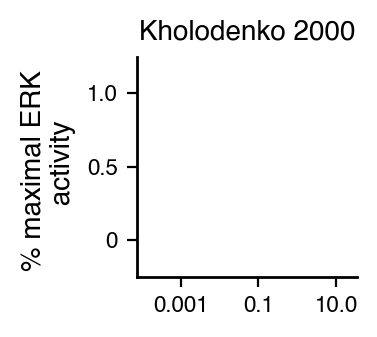

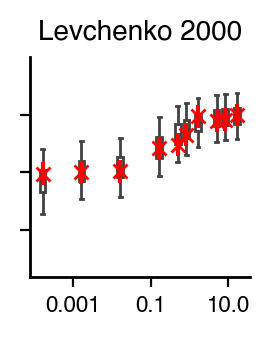

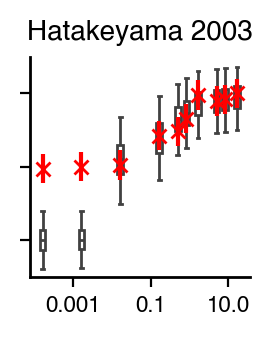

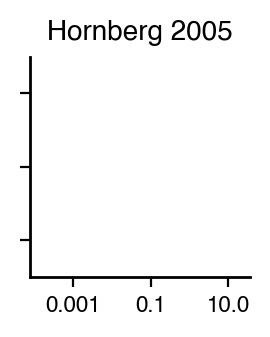

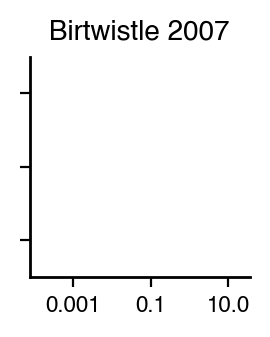

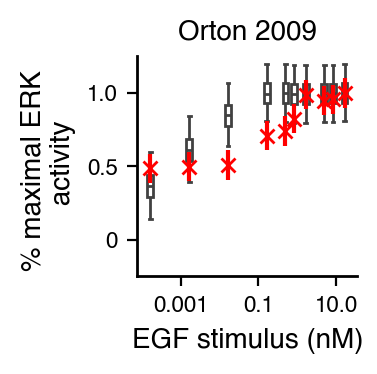

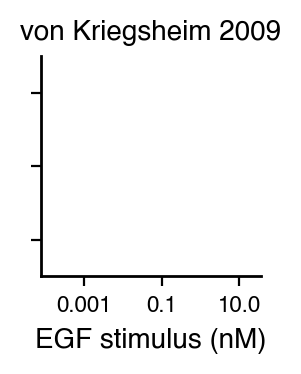

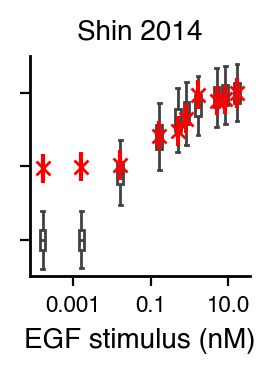

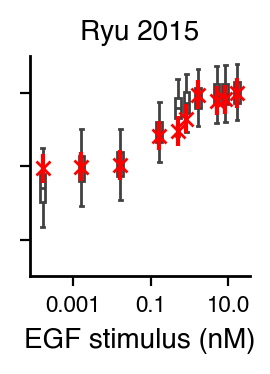

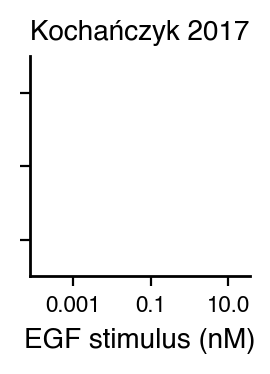

In [ ]:
# fig, ax = plot_stimulus_response_curve(K_2000_post, data, inputs, input_name='EGF stimulus (nM)', 
#                                  output_name='% maximal ERK \n activity', box_color='w', data_color='r',
#                                  data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
# ax.set_ylim([-0.25, 1.25])
# ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
# ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# # ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_xlabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
# ax.set_title('Kholodenko 2000', fontsize=10.0)

fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '0.5', '1.0'], fontsize=8)
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
# ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_xlim([7.745996376990207e-05, 35.293858931387774])
ax.set_title('Kholodenko 2000', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/K_2000_posterior_predictive.pdf', transparent=True)


fig, ax = plot_stimulus_response_curve(L_2000_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
# ax.set_ylim([-0.25, 1.25])
print(ax.get_ylim())
ax.set_yticks([0, 0.5, 1.0])
ax.set_xscale('log')
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
# ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Levchenko 2000', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/L_2000_posterior_predictive.pdf', transparent=True)

print(ax.get_xlim())
fig, ax = plot_stimulus_response_curve(HK_2003_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Hatakeyama 2003', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/HK_2003_posterior_predictive.pdf', transparent=True)

# TODO: Hornberg 2005
fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
# ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
ax.set_xlim([7.745996376990207e-05, 35.293858931387774507658])
# ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Hornberg 2005', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/H_2005_posterior_predictive.pdf', transparent=True)

# TODO: Birtwistle 2007
fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
# ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
ax.set_xlim([7.745996376990207e-05, 35.293858931387774507658])
# ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Birtwistle 2007', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/B_2007_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(O_2009_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '0.5', '1.0'], fontsize=8)
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_title('Orton 2009', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/O_2009_posterior_predictive.pdf', transparent=True)

# TODO: von Kriegsheim 2009
fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
# ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_xlim([7.745996376990207e-05, 35.293858931387774])
ax.set_ylabel('')
ax.set_title('von Kriegsheim 2009', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/VK_2009_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(S_2014_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Shin 2014', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/S_2014_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(R_2015_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Ryu 2015', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/R_2015_posterior_predictive.pdf', transparent=True)

fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
# ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_xlim([7.745996376990207e-05, 35.293858931387774])
ax.set_ylabel('')
ax.set_title('Kochańczyk 2017', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/real_data/K_2017_posterior_predictive.pdf', transparent=True)